# Foursquare dataset next-POI Recommendation System

First off we import all the necessary libraries:

In [30]:
 %pip install lightning geohash2 wandb folium shapely geopandas polars==0.20.25 

Note: you may need to restart the kernel to use updated packages.


In [31]:
 #from google.colab import drive

 #drive.mount("/content/drive")

In [32]:
import polars as rs
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as pl
import lightning.pytorch as torchpl
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import LabelEncoder
from dataclasses import dataclass
import wandb
from rich import print

In [33]:
import os

# define WANDB_NOTEBOOK_NAME
os.environ["WANDB_NOTEBOOK_NAME"] = "train.ipynb"

In [34]:
import gc

gc.collect()
# clean CUDA memory
torch.cuda.empty_cache()

# sometimes jupyter notebook does not release memory, we leave this here so a run-all
# can *sometimes* fix leaks

Next, we load the data, we utilize `polars` since it is much more efficient than `pandas` and can handle large datasets with ease.

In [35]:
columns = ["user", "poi", "date", "TZ"]

DATASET_PATH = "dataset_TIST2015\dataset_TIST2015_Checkins.txt"

data = rs.read_csv(
    DATASET_PATH,
    has_header=False,
    low_memory=True,
    separator="\t",
)
data.columns = columns

In [36]:
data

user,poi,date,TZ
i64,str,str,i64
50756,"""4f5e3a72e4b053fd6a4313f6""","""Tue Apr 03 18:00:06 +0000 2012""",240
190571,"""4b4b87b5f964a5204a9f26e3""","""Tue Apr 03 18:00:07 +0000 2012""",180
221021,"""4a85b1b3f964a520eefe1fe3""","""Tue Apr 03 18:00:08 +0000 2012""",-240
66981,"""4b4606f2f964a520751426e3""","""Tue Apr 03 18:00:08 +0000 2012""",-300
21010,"""4c2b4e8a9a559c74832f0de2""","""Tue Apr 03 18:00:09 +0000 2012""",240
…,…,…,…
16349,"""4c957755c8a1bfb7e89024f3""","""Mon Sep 16 23:24:11 +0000 2013""",-240
256757,"""4c8bbb6d9ef0224bd2d6667b""","""Mon Sep 16 23:24:13 +0000 2013""",-180
66425,"""513e82a5e4b0ed4f0f3bcf2d""","""Mon Sep 16 23:24:14 +0000 2013""",-180


Differently from what suggested by the professor, we utilize the full TIST2015 dataset, which has a far greater scale compared to the reduced NY one. However, by following the pruning steps detailed in the paper (http://dx.doi.org/10.1145/3477495.3531989, section 5.1), we obtain sequences that are much smaller in size, resulting in a dataset that is usable on Google Colab's free tier (as required by the assignment).

In [37]:
data_users = (
    data.lazy()
    .group_by("user")
    .agg(
        [
            rs.col("poi").n_unique().alias("n_pois"),
            rs.col("poi").count().alias("n_checkins"),
            # turn the rest into a list
            rs.col("poi").alias("pois"),
            rs.col("date").alias("dates"),
            rs.col("TZ").alias("TZs"),
        ]
    )
).collect()

In [38]:
data_users.describe()

statistic,user,n_pois,n_checkins,pois,dates,TZs
str,f64,f64,f64,f64,f64,f64
"""count""",266909.0,266909.0,266909.0,266909.0,266909.0,266909.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",133455.0,56.477459,124.62537,null,null,null
"""std""",77050.135837,45.968603,140.692138,null,null,null
"""min""",1.0,1.0,1.0,null,null,null
"""25%""",66728.0,30.0,61.0,null,null,null
"""50%""",133455.0,49.0,93.0,null,null,null
"""75%""",200182.0,71.0,148.0,null,null,null
"""max""",266909.0,1246.0,5430.0,null,null,null


## Data Preprocessing

In [39]:
data_culled = data_users.filter(
    (rs.col("n_checkins") > 20) & (rs.col("n_checkins") < 50)
).drop_nulls()

Since the original dataset is huge, we delete it and call the python garbage collector to free up memory. We then proceed with the second pruning step (frequency-based pruning) as detailed in the paper.

In [40]:
del data
del data_users

import gc

gc.collect()

0

In [41]:
# print lengths

print(data_culled["pois"].list.len().min(), data_culled["pois"].list.len().max())

21 49

In [42]:
# extract unique elements from each lists in data_culled["pois"]
out = data_culled.with_columns(
    [
        rs.col("pois").list.unique(),
        rs.col("pois").list.unique().list.len().alias("n_unique_pois"),
    ]
)

In [43]:
out

user,n_pois,n_checkins,pois,dates,TZs,n_unique_pois
i64,u32,u32,list[str],list[str],list[i64],u32
126755,20,21,"[""4adb5d16f964a520732621e3"", ""4a8caeb8f964a520de0e20e3"", … ""4d1b87d31356224b99eb07be""]","[""Fri May 04 23:19:22 +0000 2012"", ""Thu May 10 23:34:21 +0000 2012"", … ""Sun Aug 04 21:04:25 +0000 2013""]","[-240, -240, … -420]",20
224681,37,48,"[""4af52c87f964a52086f821e3"", ""4a76d917f964a52031e31fe3"", … ""50265ebd011cab28b6fa6e8b""]","[""Wed Apr 04 17:22:18 +0000 2012"", ""Wed Apr 11 02:50:24 +0000 2012"", … ""Fri Aug 02 19:28:36 +0000 2013""]","[-240, -240, … -420]",37
249714,32,45,"[""50499108e4b0e6163516dcda"", ""4c3c60624bc9a5938a86d271"", … ""4c6fe7a6fa49a1cde13ba4e3""]","[""Tue May 29 11:37:30 +0000 2012"", ""Fri Jun 08 15:27:52 +0000 2012"", … ""Fri Jun 07 13:18:51 +0000 2013""]","[480, 480, … 480]",32
202131,18,26,"[""4b5d69caf964a520475c29e3"", ""4bcb390c0687ef3b3238ddcc"", … ""4b19f917f964a520abe623e3""]","[""Sun May 13 10:22:11 +0000 2012"", ""Sun May 13 10:22:11 +0000 2012"", … ""Wed Apr 17 11:41:35 +0000 2013""]","[540, 540, … 540]",18
114435,33,37,"[""4cf6c56ee308236a84fae7ac"", ""49bc636bf964a52032541fe3"", … ""40807380f964a52080f21ee3""]","[""Fri Apr 20 17:10:45 +0000 2012"", ""Fri Apr 20 18:39:12 +0000 2012"", … ""Sat Sep 07 21:18:45 +0000 2013""]","[-300, -300, … -420]",33
…,…,…,…,…,…,…
649,39,45,"[""4bef83dcb0b376b02ddfdab3"", ""4dbd5e4b107ff2aa48c00a1c"", … ""50680c59e4b01437c99262b9""]","[""Fri Oct 12 04:39:31 +0000 2012"", ""Sat Oct 13 13:28:49 +0000 2012"", … ""Wed Mar 13 11:01:41 +0000 2013""]","[420, 420, … 420]",39
21094,36,39,"[""4b574037f964a520612d28e3"", ""4b2460d1f964a520cc6624e3"", … ""4ca54c06965c9c74264bc7fa""]","[""Sun Jul 01 05:59:42 +0000 2012"", ""Fri Jul 06 11:57:27 +0000 2012"", … ""Sat Dec 01 12:35:52 +0000 2012""]","[480, 480, … 480]",36
108522,25,29,"[""4dc7bccf7d8b14fb4660677d"", ""4d397444bf6d54811952c3e1"", … ""4d0cc37beea9b60c7e2d5a3f""]","[""Wed Apr 18 12:50:12 +0000 2012"", ""Thu Apr 19 11:26:35 +0000 2012"", … ""Wed May 01 10:39:38 +0000 2013""]","[120, 120, … 120]",25


In [44]:
l = out["pois"][0].to_list()
len(set(l))  # print number of unique POIs in first sequence

20

In [45]:
l2 = data_culled["pois"][0].to_list()
len(l2)  # print sequence length of first user

21

In [46]:
len(set(l2))  # confirm that the two match

20

In [47]:
# run a Polars query to obtain all the frequent POIs, the ones expected to survive the filtering
unique_pois = out["pois"]
frequent_pois = unique_pois.list.explode().value_counts().filter(rs.col("count") >= 10)

In [48]:
frequent_pois

pois,count
str,u32
"""4ff680fee4b0cc077daa0eab""",10
"""4a19c1def964a520497a1fe3""",19
"""4b7486dff964a520f4e12de3""",10
"""4c279d763703d13a5a4aa736""",22
"""4b0588c7f964a520e9d922e3""",32
…,…
"""4b9186c0f964a520f0c233e3""",41
"""4b8b605bf964a520f99d32e3""",16
"""4b5585f7f964a5206ee627e3""",16


In [49]:
frequent_pois = frequent_pois["pois"]
frequent_pois = set(frequent_pois.to_list())

In [50]:
data_culled

user,n_pois,n_checkins,pois,dates,TZs
i64,u32,u32,list[str],list[str],list[i64]
126755,20,21,"[""4adb5d16f964a520732621e3"", ""4adf8384f964a520577b21e3"", … ""4ae63521f964a5209ea521e3""]","[""Fri May 04 23:19:22 +0000 2012"", ""Thu May 10 23:34:21 +0000 2012"", … ""Sun Aug 04 21:04:25 +0000 2013""]","[-240, -240, … -420]"
224681,37,48,"[""4dd46566c65be32e5f84a583"", ""4b06ac13f964a52079ee22e3"", … ""4b5e037df964a520307929e3""]","[""Wed Apr 04 17:22:18 +0000 2012"", ""Wed Apr 11 02:50:24 +0000 2012"", … ""Fri Aug 02 19:28:36 +0000 2013""]","[-240, -240, … -420]"
249714,32,45,"[""4de99dd022713dd9737e70ce"", ""4eba254c6da17451ddc17beb"", … ""4fb84f7c754acd863d480587""]","[""Tue May 29 11:37:30 +0000 2012"", ""Fri Jun 08 15:27:52 +0000 2012"", … ""Fri Jun 07 13:18:51 +0000 2013""]","[480, 480, … 480]"
202131,18,26,"[""4b5d69caf964a520475c29e3"", ""4b5d69caf964a520475c29e3"", … ""4d39b57034ee37048ba46f9b""]","[""Sun May 13 10:22:11 +0000 2012"", ""Sun May 13 10:22:11 +0000 2012"", … ""Wed Apr 17 11:41:35 +0000 2013""]","[540, 540, … 540]"
114435,33,37,"[""4a6c86f2f964a520b9d01fe3"", ""4b328d28f964a520650e25e3"", … ""4c05a764191f20a11473e314""]","[""Fri Apr 20 17:10:45 +0000 2012"", ""Fri Apr 20 18:39:12 +0000 2012"", … ""Sat Sep 07 21:18:45 +0000 2013""]","[-300, -300, … -420]"
…,…,…,…,…,…
649,39,45,"[""4b539f61f964a5200ba527e3"", ""4e4146eaa809968085336021"", … ""4ef60deab63446a5079e6133""]","[""Fri Oct 12 04:39:31 +0000 2012"", ""Sat Oct 13 13:28:49 +0000 2012"", … ""Wed Mar 13 11:01:41 +0000 2013""]","[420, 420, … 420]"
21094,36,39,"[""4edf655d8b81340ef0ed2279"", ""4b058805f964a520fbac22e3"", … ""4b058805f964a520edac22e3""]","[""Sun Jul 01 05:59:42 +0000 2012"", ""Fri Jul 06 11:57:27 +0000 2012"", … ""Sat Dec 01 12:35:52 +0000 2012""]","[480, 480, … 480]"
108522,25,29,"[""4e634e57d164ddd5e62415ae"", ""4e77071952b1c8e51a225e05"", … ""4f96c943e4b00200cdb936af""]","[""Wed Apr 18 12:50:12 +0000 2012"", ""Thu Apr 19 11:26:35 +0000 2012"", … ""Wed May 01 10:39:38 +0000 2013""]","[120, 120, … 120]"


In [51]:
data_culled = data_culled.with_columns(
    [
        rs.col("pois")
        .list.eval(
            rs.element().is_in(frequent_pois),
        )
        .alias("is_frequent")
    ]
)  # prep mask

In [52]:
final_data = (
    data_culled.lazy()
    .explode(
        [
            "pois",
            "dates",
            "TZs",
            "is_frequent",
        ]
    )
    .group_by("user")
    .agg(
        [
            rs.col("pois").filter(rs.col("is_frequent")).alias("pois"),
            rs.col("dates").filter(rs.col("is_frequent")).alias("dates"),
            rs.col("TZs").filter(rs.col("is_frequent")).alias("TZs"),
            rs.col("pois").filter(rs.col("is_frequent")).n_unique().alias("n_pois"),
            rs.col("pois").filter(rs.col("is_frequent")).count().alias("n_checkins"),
        ]
    )
    .filter(rs.col("n_checkins") > 0)
    .filter(rs.col("n_pois") > 0)
    .collect()
)  # filter out infrequent pois and users with no pois

In [53]:
final_data.describe()

statistic,user,pois,dates,TZs,n_pois,n_checkins
str,f64,f64,f64,f64,f64,f64
"""count""",19862.0,19862.0,19862.0,19862.0,19862.0,19862.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",156852.822274,null,null,null,6.123452,8.831437
"""std""",76314.892884,null,null,null,4.609024,6.877662
"""min""",49.0,null,null,null,1.0,1.0
"""25%""",95613.0,null,null,null,3.0,4.0
"""50%""",167846.0,null,null,null,5.0,7.0
"""75%""",224576.0,null,null,null,8.0,12.0
"""max""",266909.0,null,null,null,32.0,46.0


At this stage, culling is done, we can appreciate that `polars`'s SQL/functional-style API is different from Pandas, but it is very powerful and efficient.

The next step is geohashing the POIs, that is, we want to convert the latitude-longitude positions of the POIs into a grid-based geohash representation, which will form the basis for our network's embeddings.

In [54]:
import geohash2 as gh

POI_DATASET = "dataset_TIST2015\dataset_TIST2015_POIs.txt"

pois = rs.read_csv(
    POI_DATASET,
    has_header=False,
    low_memory=True,
    separator="\t",
)
pois.columns = ["poi", "lat", "long", "category", "country"]
pois = pois.drop("category").drop("country")

In [55]:
%pip install shapely geopandas

Note: you may need to restart the kernel to use updated packages.


C:\Users\Martina\AppData\Local\Temp\ipykernel_12248\2227167758.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


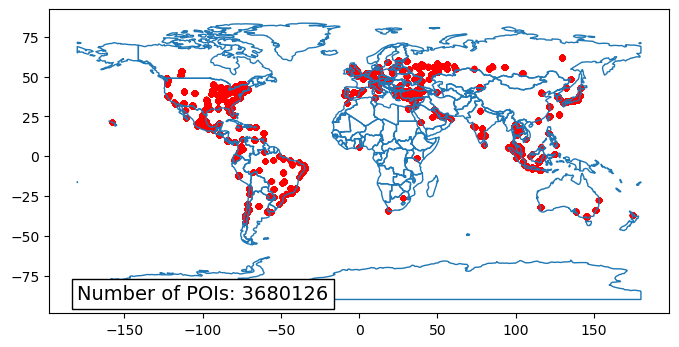

<Figure size 640x480 with 0 Axes>

In [56]:
from folium import plugins
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

geometry = [Point(lon, lat) for lon, lat in zip(pois["long"], pois["lat"])]
gdf = gpd.GeoDataFrame(pois, geometry=geometry, crs="EPSG:4326")

# # Crea una mappa di sfondo
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
n_pois=pois["poi"].n_unique()
fig, ax = plt.subplots(figsize=(8, 6))
world.boundary.plot(ax=ax, linewidth=1)
gdf.plot(ax=ax, markersize=8, color="red", alpha=0.5, legend=True)
plt.text(-180, -90, f"Number of POIs: {n_pois}", fontsize=14, backgroundcolor="white", bbox=dict(facecolor="white", alpha=1))
plt.show()
plt.savefig("report/poi_original.png")



In [57]:
pois = (
    pois.lazy()
    .filter(rs.col("poi").is_in(frequent_pois))
    .select(
        [
            rs.col("poi"),
            rs.struct(
                [
                    rs.col("lat").cast(rs.Float32),
                    rs.col("long").cast(rs.Float32),
                ]
            )
            .alias("location")
            .map_elements(
                lambda s: gh.encode(s["lat"], s["long"], precision=6),
                return_dtype=rs.String,
            )
            .alias("geohash"),
        ]
    )
    .collect()
)
poi_geo_dict = dict(zip(pois["poi"], pois["geohash"]))

C:\Users\Martina\AppData\Local\Temp\ipykernel_12248\362917435.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


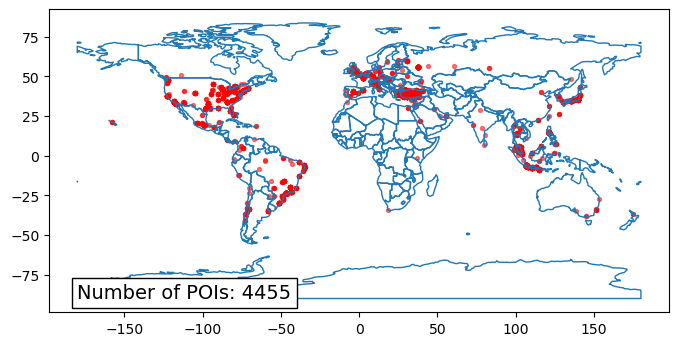

<Figure size 640x480 with 0 Axes>

In [58]:
#show the final data on the map
#decode lat and long from geohash
def decode_geohash(geohash):
    lat, long = gh.decode(geohash)
    return long, lat

geometry = [Point(lon, lat) for lon, lat in map(decode_geohash, poi_geo_dict.values())]
gdf = gpd.GeoDataFrame(pois, geometry=geometry, crs="EPSG:4326")

# # Crea una mappa di sfondo
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# print number of unique POIs
n_pois=pois["poi"].n_unique()
fig, ax = plt.subplots(figsize=(8, 6))
world.boundary.plot(ax=ax, linewidth=1)
gdf.plot(ax=ax, markersize=8, color="red", alpha=0.5, legend=True)
plt.text(-180, -90, f"Number of POIs: {n_pois}", fontsize=14, backgroundcolor="white", bbox=dict(facecolor="white", alpha=1))
plt.show()
plt.savefig("report/poi_after_processing")



In [77]:
# for each row in final_data, add the geohash of the pois by hitting the poi_geo_dict

final_data = final_data.with_columns(
    [
        rs.col("pois")
        .map_elements(
            lambda s: [poi_geo_dict[s] for s in s],
            return_dtype=rs.List(rs.String),
        )
        .alias("geohashes")
    ]
)

In [78]:

geometry = [Point(lon, lat) for lon, lat in map(decode_geohash, final_data["geohashes"][0])]
gdf = gpd.GeoDataFrame(final_data, geometry=geometry, crs="EPSG:4326")

# # Crea una mappa di sfondo
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Plotta i punti sullo sfondo della mappa
fig, ax = plt.subplots(figsize=(10, 6))
world.boundary.plot(ax=ax, linewidth=1)
gdf.plot(ax=ax, markersize=10, color="red", alpha=0.5, legend=True)
plt.title("Dataset Division based on GeoPandas")
plt.show()

ComputeError: `to_numpy` not supported for dtype List(String)

In [28]:
final_data["dates"][79].to_list()  # check out a temporal sequence

['Mon Dec 31 12:47:12 +0000 2012',
 'Wed Jan 02 13:31:04 +0000 2013',
 'Sun Feb 24 16:11:47 +0000 2013',
 'Fri Mar 08 13:38:04 +0000 2013',
 'Fri Apr 05 13:23:56 +0000 2013',
 'Sun Apr 07 14:20:07 +0000 2013',
 'Fri Apr 12 13:09:16 +0000 2013',
 'Fri Apr 19 11:12:18 +0000 2013',
 'Sun Apr 21 15:00:22 +0000 2013',
 'Fri May 03 11:12:31 +0000 2013',
 'Fri May 17 11:14:58 +0000 2013',
 'Sun May 19 14:17:22 +0000 2013',
 'Sun Jun 16 14:31:37 +0000 2013',
 'Tue Aug 27 15:06:02 +0000 2013',
 'Thu Sep 05 09:12:26 +0000 2013',
 'Sat Sep 14 12:14:25 +0000 2013']

In [29]:
final_data["TZs"][79].to_list()  # ... and the corresponding timezones

[60, 60, 60, 60, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120]

The work *might* seem over, however, we still have timezones to account for, we want to normalize everything according to GMT, so we convert the timestamps accordingly.

In [30]:
import datetime


def UTC_to_local(utc, tz):

    date = datetime.datetime.strptime(utc, "%a %b %d %H:%M:%S %z %Y")
    date = date.replace(tzinfo=datetime.timezone.utc)

    # shift by tz offset
    date = date.astimezone(datetime.timezone(datetime.timedelta(minutes=tz)))

    date_s = datetime.datetime.strftime(date, "%Y-%m-%d %H:%M:%S")
    return date_s


def to_UNIX_time(date):
    return datetime.datetime.strptime(
        date, "%Y-%m-%d %H:%M:%S"
    ).timestamp()  # we use UNIX time as a key for sorting the POIs in our polars query

In [31]:
UTC_to_local("Mon May 21 15:53:01 +0000 2012", -420)  # example of usage

'2012-05-21 08:53:01'

In [32]:
final_data = final_data.with_columns(
    [
        rs.struct([rs.col("dates"), rs.col("TZs")])
        .alias("times")
        .map_elements(
            lambda struct: [
                UTC_to_local(date, tz)
                for date, tz in zip(struct["dates"], struct["TZs"])
            ],
            return_dtype=rs.List(rs.String),
        )
    ]
)  # This performs timezone conversion

In [33]:
final_sorted = final_data.select(  # sort the times
    [
        rs.col("user"),
        rs.struct(
            [
                rs.col("pois"),
                rs.col("times"),
            ]
        ).map_elements(
            lambda struct: [
                poi
                for poi, _ in sorted(
                    zip(  # here we sort the POIs struct by UNIX timestamps of the GMT times
                        struct["pois"], [to_UNIX_time(date) for date in struct["times"]]
                    ),
                    key=lambda s: s[1],
                )
            ],
            return_dtype=rs.List(rs.String),
        ),
        rs.struct(
            [
                rs.col("geohashes"),
                rs.col("times"),
            ]
        ).map_elements(
            lambda struct: [
                geo
                for geo, _ in sorted(
                    zip(
                        struct["geohashes"],  # same thing goes on for geohashes
                        [to_UNIX_time(date) for date in struct["times"]],
                    ),
                    key=lambda s: s[1],
                )
            ],
            return_dtype=rs.List(rs.String),
        ),
        rs.col("times")
        .map_elements(
            lambda dates: sorted(dates, key=to_UNIX_time),
            return_dtype=rs.List(rs.String),
        )
        .alias("times_sorted"),
        rs.col("n_checkins"),
    ]
)

# P.S, admittedly, it would have been more efficient to encode the geohashes *after* sorting the POIs,
# so that we could save on the sorting of the geohashes. Tough luck, you can't win 'em all.

In [34]:
final_sorted

user,pois,geohashes,times_sorted,n_checkins
i64,list[str],list[str],list[str],u32
71312,"[""4c451398f799e21e5fd0aea2"", ""4be574b55254d13a978560e1"", … ""4c4d682067929c74c72a449b""]","[""wdw4cp"", ""wdw51f"", … ""wdw40m""]","[""2013-04-03 17:59:26"", ""2013-04-18 16:53:17"", … ""2013-08-18 16:52:57""]",6
112205,"[""4b2d0e1af964a52037cd24e3"", ""4b0f05d9f964a520495e23e3"", … ""4b2d0e1af964a52037cd24e3""]","[""6gycd7"", ""6gyf42"", … ""6gycd7""]","[""2012-04-11 07:05:07"", ""2012-04-11 19:31:07"", … ""2012-12-27 16:21:47""]",15
114828,"[""4bc5843eccbcef3bf49ce6d2"", ""439ec330f964a520102c1fe3"", … ""4a8a103af964a520c90920e3""]","[""djmvmq"", ""9q5c1e"", … ""djgzqs""]","[""2012-10-11 13:16:00"", ""2012-10-25 00:24:32"", … ""2013-05-27 08:22:11""]",5
24125,"[""4bd19cd6b221c9b682c7d5d0"", ""4c932272911b8cfada48f3b5"", ""4bc928e7b6c49c74b2138e91""]","[""w2q2y7"", ""w2q2yg"", ""w2q2wz""]","[""2012-04-04 20:21:30"", ""2012-04-08 11:18:20"", ""2012-04-08 18:54:07""]",3
259152,"[""4b15505cf964a5206db023e3"", ""4a3b08fdf964a52086a01fe3"", ""49f47c7cf964a5200d6b1fe3""]","[""dqcm6f"", ""dqcqzk"", ""dqcx2r""]","[""2012-08-12 14:18:04"", ""2013-02-01 18:09:05"", ""2013-06-16 11:58:06""]",3
…,…,…,…,…
208014,"[""4c217a8034faef3b396d586d"", ""4c217a8034faef3b396d586d"", … ""4c07d717da13c9281b136c02""]","[""6ztxb8"", ""6ztxb8"", … ""6zv80f""]","[""2012-12-17 20:23:14"", ""2012-12-22 13:39:34"", … ""2013-02-25 16:24:56""]",4
200934,"[""4b580878f964a520384928e3"", ""4b5bc6b0f964a520861529e3"", … ""4b5e310bf964a520d38229e3""]","[""xn0m75"", ""xn0m5m"", … ""wvuxp6""]","[""2013-03-22 15:05:02"", ""2013-03-27 14:49:26"", … ""2013-09-13 08:16:58""]",5
201467,"[""4b6d5f18f964a52069732ce3"", ""4b1b5138f964a520c9fa23e3"", … ""4b5d329ef964a520405629e3""]","[""eyeucs"", ""sr2vy9"", … ""ezjmu5""]","[""2012-05-16 19:12:32"", ""2012-05-16 23:39:33"", … ""2013-09-04 09:12:36""]",10


we now need to obtain a dataframe containing: each POI, it's geohash, and a set of all the check-ins it appears in
this is just one `polars` query away!

In [35]:
pois_checkins = final_sorted.explode(["pois", "geohashes"]).drop("n_checkins")

pois_checkins = (
    pois_checkins.with_columns(
        [
            rs.col("geohashes").map_elements(lambda s: s[:4], rs.String).alias("g4"),
        ]
    )
    .drop("geohashes")
    .group_by(["pois", "g4"])
    .agg([rs.col("times_sorted").flatten().alias("checkin_times")])
)

In [36]:
pois_checkins  # with this we can *efficiently* build our POI-POI spatial-temporal graphs

pois,g4,checkin_times
str,str,list[str]
"""4b7bdb91f964a5200a712fe3""","""w22r""","[""2012-05-19 17:53:21"", ""2012-06-08 19:24:02"", … ""2013-06-20 11:39:14""]"
"""4b8bb438f964a520ada732e3""","""xn32""","[""2012-05-16 12:39:09"", ""2012-05-16 13:09:12"", … ""2013-09-13 08:16:58""]"
"""4aed9d64f964a520dbcd21e3""","""9vrf""","[""2012-05-17 02:52:08"", ""2012-05-25 18:02:14"", … ""2013-06-21 11:00:44""]"
"""4bb9151bb35776b00099c901""","""sxk9""","[""2012-10-24 11:57:09"", ""2013-03-27 11:46:40"", … ""2012-12-30 13:46:01""]"
"""4bca4c3f68f976b06a2a5f83""","""66j9""","[""2012-04-14 16:36:51"", ""2012-04-16 14:13:05"", … ""2013-06-26 10:01:21""]"
…,…,…
"""4c255dca905a0f4764796160""","""u9ed""","[""2012-07-05 08:39:48"", ""2012-09-15 16:00:31"", … ""2013-04-20 10:49:01""]"
"""4b81a7fdf964a520b8b530e3""","""d1u0""","[""2012-12-08 13:55:42"", ""2013-07-02 11:07:09"", … ""2012-05-05 17:13:38""]"
"""4ba2f1b2f964a520312438e3""","""w2cq""","[""2012-12-22 15:13:27"", ""2012-12-23 11:51:41"", … ""2013-07-30 16:13:13""]"


In [ ]:
def UTC_to_weekslot(utc: str) -> int:
    """UTC_to_weekslot converts a UTC timestamp to a weekslot.

    Parameters
    ----------
    utc : str
        A string representing a UTC timestamp.

    Returns
    -------
    int
        A weekslot in the range [0, 56).
    """

    date = datetime.datetime.strptime(utc, "%Y-%m-%d %H:%M:%S")
    week = date.weekday()
    hour = date.hour

    return week * 8 + hour // 3

Next, we want to encode all of our inputs for our neural networks, this could *probably* be done
with polars magic, but it's too delicate and we prefer classic for-looping.

In [ ]:
encoder_dict = {
    "users": LabelEncoder(),
    "pois": LabelEncoder(),
    "g2": LabelEncoder(),
    "g3": LabelEncoder(),
    "g4": LabelEncoder(),
    "g5": LabelEncoder(),
    "g6": LabelEncoder(),
}

encoded_data = {
    "users": [],
    "pois": [],
    "g2": [],
    "g3": [],
    "g4": [],
    "g5": [],
    "g6": [],
}

unique_data = {
    "users": set(),
    "pois": set(),
    "g2": set(),
    "g3": set(),
    "g4": set(),
    "g5": set(),
    "g6": set(),
}

# quick and dirty encoding:
# 1. put every unique symbol in a list
# 2. fit the respective encoder
# 3. transform the lists

for i, row in enumerate(final_sorted.iter_rows()):

    user, pois, geohashes, times_sorted, n_checkins = row

    g2 = [geo[:2] for geo in geohashes]
    g3 = [geo[:3] for geo in geohashes]
    g4 = [geo[:4] for geo in geohashes]
    g5 = [geo[:5] for geo in geohashes]
    g6 = [geo[:6] for geo in geohashes]  # redundant, but I like symmetry

    unique_data["users"].add(user)
    unique_data["pois"].update(pois)
    unique_data["g2"].update(g2)
    unique_data["g3"].update(g3)
    unique_data["g4"].update(g4)
    unique_data["g5"].update(g5)
    unique_data["g6"].update(g6)

for property, enc, data in zip(
    encoder_dict.keys(), encoder_dict.values(), unique_data.values()
):
    enc.fit(list(data))
    encoder_dict[property] = enc

In [ ]:
# this could be optimized, right now it takes a while, at least we have a nice progress bar to look at

ds_size = len(final_sorted)

for i, row in tqdm(enumerate(final_sorted.iter_rows()), total=ds_size):

    user, pois, geohashes, times_sorted, n_checkins = row

    g2 = [geo[:2] for geo in geohashes]
    g3 = [geo[:3] for geo in geohashes]
    g4 = [geo[:4] for geo in geohashes]
    g5 = [geo[:5] for geo in geohashes]
    g6 = [geo[:6] for geo in geohashes]

    encoded_data["users"].append(encoder_dict["users"].transform([user])[0])
    encoded_data["pois"].append(encoder_dict["pois"].transform(pois))
    encoded_data["g2"].append(encoder_dict["g2"].transform(g2))
    encoded_data["g3"].append(encoder_dict["g3"].transform(g3))
    encoded_data["g4"].append(encoder_dict["g4"].transform(g4))
    encoded_data["g5"].append(encoder_dict["g5"].transform(g5))
    encoded_data["g6"].append(encoder_dict["g6"].transform(g6))

    # sum 1 to all values to avoid 0s
    encoded_data["users"][-1] += 1
    encoded_data["pois"][-1] += 1
    encoded_data["g2"][-1] += 1
    encoded_data["g3"][-1] += 1
    encoded_data["g4"][-1] += 1
    encoded_data["g5"][-1] += 1
    encoded_data["g6"][-1] += 1

In [ ]:
# check that we left space for the padding token
min((arr.min() for arr in encoded_data["pois"]))

In [ ]:
pois_checkins

In [ ]:
# we also encode the graph dataframe so we can build the graphs

pois_checkins = (
    pois_checkins.lazy()
    .with_columns(
        [
            rs.col("pois").map_elements(
                lambda s: encoder_dict["pois"].transform([s])[0] + 1, rs.Int64
            ),
            rs.col("g4").map_elements(
                lambda s: encoder_dict["g4"].transform([s])[0] + 1, rs.Int64
            ),  # apply utc_to_weekslot to each timestamp in the list
            rs.col("checkin_times").map_elements(
                lambda s: [UTC_to_weekslot(date) for date in s], rs.List(rs.Int64)
            ),
        ]
    )
    .sort("pois")
    .collect()
)

In [ ]:
# add fictitious POI 0 to the graph, with nonexistent geohash and no timeslot, so we get a 0 row and column for the padding token
fake_datapoint = rs.DataFrame(
    {
        "pois": [0],
        "g4": [pois_checkins["g4"].max() + 42],
        "checkin_times": [[43]],
    }
)
# this is a lot of work since polars dataframes are immutable by default, we have to run a query to change the 43 into an empty list
# we NEED the 43 otherwise polars won't infer the datatype of the list

fake_datapoint = fake_datapoint.with_columns(
    [rs.col("checkin_times").map_elements(lambda s: [], rs.List(rs.Int64))]
)

pois_checkins = fake_datapoint.vstack(pois_checkins)

In [ ]:
spatial_row = np.array(pois_checkins["g4"].to_list()).reshape(-1, 1)

In [ ]:
# outer product using equality
spatial_graph = (spatial_row == spatial_row.T).astype(np.int32)
spatial_graph[0, 0] = (
    0  # the fake g4 is still equal to itself, we suppress this equality
)
spatial_graph = torch.tensor(spatial_graph)

In [ ]:
temporal_row = pois_checkins["checkin_times"].to_list()

In [ ]:
temporal_graph = np.zeros((spatial_row.shape[0], spatial_row.shape[0]))

In [ ]:
temporal_sets = [np.array(list(set(row))) for row in temporal_row]

In [ ]:
time_sets = torch.zeros((len(temporal_sets), 56), dtype=torch.int8)

for i, r in enumerate(temporal_row):
    indices = torch.tensor(r, dtype=torch.long)
    time_sets[i, indices] = 1

In [ ]:
time_sets.shape

In [ ]:
# AND outer product

intersection = time_sets @ time_sets.T
union = time_sets.unsqueeze(1) | time_sets.unsqueeze(0)
union = union.sum(dim=2)
iou = intersection / union

In [ ]:
temporal_graph = iou >= 0.9
# cast to int
temporal_graph = temporal_graph.int()

In [ ]:
temporal_graph[0, :].sum()

We print information about the sparsity of the graphs, we note that
the sparsity of the graphs is similar to that of the paper.

In [ ]:
temporal_density = (
    temporal_graph.sum() / (temporal_graph.shape[0] * temporal_graph.shape[1])
).item()
spatial_density = (
    spatial_graph.sum() / (spatial_graph.shape[0] * spatial_graph.shape[1])
).item()

print(f"Temporal sparsity: {(1 - temporal_density) * 100:.2f}%")

print(f"Spatial sparsity: {(1 - spatial_density) * 100:.2f}%")

## Train Test Split

We now generate two dataframes from the `encoded_data` dataframe, one for training and one for testing.

First, we have to drop every sequence that has less than 4 timestamps, as we wouldn't be able to get the minimum of two samples for each of the sets,
we then calculate the 80% of the sequences and split the data accordingly.

In [ ]:
len(encoded_data["pois"])

In [ ]:
total_data = rs.DataFrame(encoded_data)

In [ ]:
total_data = total_data.with_columns(
    [
        rs.col("pois").list.len().alias("length"),
    ]
)

In [ ]:
total_data = total_data.with_columns(
    rs.col("length")
    .map_elements(lambda s: int(0.8 * s) - 1, rs.Int64)
    .alias("train_end")
)

In [ ]:
# drop sequences that are too short
total_data = total_data.filter(
    (
        rs.col("train_end") >= 1
    )  # at least 2 elements in the training set (1 is the index)
    & (
        rs.col("length") - (rs.col("train_end") + 1) >= 2
    )  # at least 2 elements in the validation set
)
print(total_data["length"].mean())
print(total_data.count())

In [ ]:
total_data.sort("length")  # check out the distribution of sequence lengths

In [ ]:
# Check if the shortest sequence is long enough
total_data.sort("length")["pois"][0]

In [ ]:
# slice the two dataframes
train_data = total_data.select(
    [
        rs.col("users"),
        rs.struct(
            [
                rs.col("pois"),
                rs.col("g2"),
                rs.col("g3"),
                rs.col("g4"),
                rs.col("g5"),
                rs.col("g6"),
                rs.col("train_end"),
            ]
        )
        .map_elements(
            lambda struct: [
                struct["pois"][: struct["train_end"]],
                struct["g2"][: struct["train_end"]],
                struct["g3"][: struct["train_end"]],
                struct["g4"][: struct["train_end"]],
                struct["g5"][: struct["train_end"]],
                struct["g6"][: struct["train_end"]],
            ],
            return_dtype=rs.List(rs.List(rs.Int64)),
        )
        .alias("sequences"),
    ]
)


test_data = total_data.select(
    [
        rs.col("users"),
        rs.struct(
            [
                rs.col("pois"),
                rs.col("g2"),
                rs.col("g3"),
                rs.col("g4"),
                rs.col("g5"),
                rs.col("g6"),
                rs.col("train_end"),
            ]
        )
        .map_elements(
            lambda struct: [
                struct["pois"][struct["train_end"] :],
                struct["g2"][struct["train_end"] :],
                struct["g3"][struct["train_end"] :],
                struct["g4"][struct["train_end"] :],
                struct["g5"][struct["train_end"] :],
                struct["g6"][struct["train_end"] :],
            ],
            return_dtype=rs.List(rs.List(rs.Int64)),
        )
        .alias("sequences"),
    ]
)

In [ ]:
def explode_dict(d):
    """explode_dict Convert packed polars dataframe into a neat python dict

    Parameters
    ----------
    d : Polars.DataFrame
        A polars dataframe with a struct column

    Returns
    -------
    dict
        A python dict with the same structure as the struct column
    """
    ret = {
        "users": d["users"].to_list(),
        "pois": [],
        "g2": [],
        "g3": [],
        "g4": [],
        "g5": [],
        "g6": [],
    }

    for sample in d["sequences"]:
        pois, g2, g3, g4, g5, g6 = sample
        ret["pois"].append(pois.to_list())
        ret["g2"].append(g2.to_list())
        ret["g3"].append(g3.to_list())
        ret["g4"].append(g4.to_list())
        ret["g5"].append(g5.to_list())
        ret["g6"].append(g6.to_list())

    return ret

In [ ]:
encoded_data_train = explode_dict(train_data.to_dict())
encoded_data_test = explode_dict(test_data.to_dict())

In [ ]:
total_data

In [ ]:
encoded_data_train["pois"][10]

In [ ]:
encoded_data_test["pois"][10]

In [ ]:
total_data["pois"][10].to_list()

In [ ]:
min([len(l) for l in encoded_data_test["pois"]])

## Metrics


The paper utilizes metrics that check if the target is in the top-k recommendations, we implement them here.

In [ ]:
class AccuracyAtK(nn.Module):
    def __init__(self, k: int):
        """__init__ initializes the AccuracyAtK module.

        Accuracy@k is the proportion of correct predictions in the top-k elements.

        Parameters
        ----------
        k : int
            The number of top-k elements to consider.

        """
        super().__init__()
        self.k = k

    def forward(
        self, logits: torch.Tensor, targets: torch.Tensor, padding_mask: torch.Tensor
    ) -> torch.Tensor:
        """forward computes the accuracy at k between logits and targets.

        Parameters
        ----------
        logits : torch.Tensor
            Class probability, either (B, C) or (B, T, C)
        targets : torch.Tensor
            Ground truth class indices, either (B,) or (B, T)
        padding_mask : torch.Tensor
            Padding mask, either (B,) or (B, T)

        Returns
        -------
        torch.Tensor
            The accuracy at k, a scalar-tensor.
        """

        
        predicted=logits.softmax(dim=-1)
        top_k=predicted.topk(self.k, dim=-1)[1]
        correct=(top_k==targets.unsqueeze(-1)).any(dim=-1).float()
        if padding_mask is not None:
            correct *= padding_mask.float()
            # Avoid division by zero by counting non-zero elements in the mask
            accuracy = correct.sum() / padding_mask.float().sum()
        else:
            accuracy = correct.mean()
        print("accuracy",accuracy)

        return accuracy
        '''
        
        # Gotta have at least one nasty python one-liner, in memory of the old
        # programming lab 1 bachelor course
        
        # P.S the one liner was bugged, the hubris of man...
        return (
            (
                logits.softmax(dim=-1)  # apply softmax
                .masked_fill(
                    padding_mask.unsqueeze(-1), -1e9
                )  # mask padding by imposing a very low probability (hacky)
                .topk(self.k, dim=-1)[1]  # extract top-k indices
                == targets.unsqueeze(-1)
            )
            .any(dim=-1)
            .float()
            .mean()
        )
        '''


class AccuracyAt1(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:

        predicted = logits.argmax(dim=-1)
        correct = (predicted == targets).float()
        accuracy = correct.mean()
        return accuracy


class MeanReciprocalRank(nn.Module):

    def __init__(self):
        """__init__ initializes the MeanReciprocalRank module.

        Mean reciprocal rank is the average of the reciprocal ranks of the top-k elements.

        """
        super().__init__()

    def forward(
        self, logits: torch.Tensor, targets: torch.Tensor, padding_mask: torch.Tensor
    ) -> torch.Tensor:
        """forward computes the mean reciprocal rank between logits and targets.

        Parameters
        ----------
        logits : torch.Tensor
            Class probability
        targets : torch.Tensor
            Ground truth class indices
        padding_mask : torch.Tensor
            Padding mask

        Returns
        -------
        torch.Tensor
            The mean reciprocal rank, a scalar-tensor.
        """
        
        predicted = logits.softmax(dim=-1)
        top_k = predicted.topk(logits.size(-1), dim=-1)[1]
        ranks = (top_k == targets.unsqueeze(-1)).nonzero()[:, -1].float() + 1
        reciprocal_ranks = 1.0 / ranks
        if padding_mask is not None:
            reciprocal_ranks *= padding_mask.float()
            # Avoid division by zero by counting non-zero elements in the mask
            mrr = reciprocal_ranks.sum() / padding_mask.float().sum()
        else:
            mrr = reciprocal_ranks.mean()
        return mrr

In [ ]:
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence


def rnn_collation_fn(batch):

    users = []
    pois = []
    g2 = []
    g3 = []
    g4 = []
    g5 = []
    g6 = []


    for user, poi, geo2, geo3, geo4, geo5, geo6 in batch:
        users.append(user)
        pois.append(poi)
        g2.append(geo2)
        g3.append(geo3)
        g4.append(geo4)
        g5.append(geo5)
        g6.append(geo6)


    seq = (
        torch.tensor(users, dtype=torch.long),
        pad_sequence(pois, batch_first=True, padding_value=0),
        pad_sequence(g2, batch_first=True, padding_value=0),
        pad_sequence(g3, batch_first=True, padding_value=0),
        pad_sequence(g4, batch_first=True, padding_value=0),
        pad_sequence(g5, batch_first=True, padding_value=0),
        pad_sequence(g6, batch_first=True, padding_value=0),
    )  # build a sequence

    x = (
        seq[0],
        seq[1][:, :-1],
        seq[2][:, :-1],
        seq[3][:, :-1],
        seq[4][:, :-1],
        seq[5][:, :-1],
        seq[6][:, :-1],
    )  # omit the last one for sample

    y = (
        seq[0],
        seq[1][:, 1:],
        seq[2][:, 1:],
        seq[3][:, 1:],
        seq[4][:, 1:],
        seq[5][:, 1:],
        seq[6][:, 1:],
    )  # omit the first one for ground truth

    # Take sequence lengths
    x_lengths = x[1].count_nonzero(dim=1)
    x_lengths = x_lengths.tolist()


    return x,y,x_lengths


class CheckinDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data["users"])

    def __getitem__(self, idx):

        x = (
            torch.tensor(self.data["users"][idx], dtype=torch.long),
            torch.tensor(self.data["pois"][idx], dtype=torch.long),
            torch.tensor(self.data["g2"][idx], dtype=torch.long),
            torch.tensor(self.data["g3"][idx], dtype=torch.long),
            torch.tensor(self.data["g4"][idx], dtype=torch.long),
            torch.tensor(self.data["g5"][idx], dtype=torch.long),
            torch.tensor(self.data["g6"][idx], dtype=torch.long),
        )

        return x

## Dataset and Datamodule

We then define a pytorch dataset and a custom collation function that allows us to dynamically
pad sequences to the longest one in the batch (as opposed to the longest one in the dataset)
as they are loaded during training, this gives us an edge in performance by dramatically reducing the
sparsity of our inputs.

In [ ]:
class CheckinModule(pl.LightningDataModule):
    def __init__(self, encoded_data_train, encoded_data_test, batch_size=32, workers=4):
        """__init__ initializes the CheckinModule.

        Parameters
        ----------
        encoded_data_train : Union[dict, rs.DataFrame]
            The training data.
        encoded_data_test : Union[dict, rs.DataFrame]
            The testing data.
        batch_size : int, optional
            Size of the batches, by default 32
        workers : int, optional
            Number of worker processes, by default 4
        """
        super().__init__()
        self.encoded_data_train = encoded_data_train
        self.encoded_data_test = encoded_data_test
        self.batch_size = batch_size
        self.workers = workers

        assert isinstance(self.encoded_data_train, dict) or isinstance(
            self.encoded_data_train, rs.DataFrame
        ), "encoded_data_train must be a dict or a polars DataFrame"
        assert isinstance(self.encoded_data_test, dict) or isinstance(
            self.encoded_data_test, rs.DataFrame
        ), "encoded_data_test must be a dict or a polars DataFrame"

        assert batch_size > 0, "batch_size must be a positive integer"
        assert workers >= 0, "workers must be a non-negative integer"

    def setup(self, stage=None):

        if (
            isinstance(self.encoded_data_train, dict)
            or isinstance(self.encoded_data_train, rs.DataFrame)
        ) and (
            isinstance(self.encoded_data_test, dict)
            or isinstance(self.encoded_data_test, rs.DataFrame)
        ):
            print("Loading data from dict/dataframe")
            self.train_dataset = CheckinDataset(self.encoded_data_train)
            self.test_dataset = CheckinDataset(self.encoded_data_test)

        elif isinstance(self.encoded_data_train, CheckinDataset) and isinstance(
            self.encoded_data_test, CheckinDataset
        ):
            print("Loading data from pre-instantiated datasets")
            self.train_dataset = self.encoded_data_train
            self.test_dataset = self.encoded_data_test
        else:
            raise ValueError("Invalid data type")

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.workers,
            collate_fn=rnn_collation_fn,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.workers,
            collate_fn=rnn_collation_fn,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.workers,
            collate_fn=rnn_collation_fn,
        )

    def save(self, whole_path, train_path, test_path):

        torch.save(self.train_dataset, train_path)
        torch.save(self.test_dataset, test_path)

    @staticmethod  # load without instantiating
    def load(train_path, test_path):

        train_dataset = torch.load(train_path)
        test_dataset = torch.load(test_path)

        return CheckinModule(train_dataset, test_dataset)

## Baseline model: LSTM

In [ ]:
@dataclass
class BaselineDimensions:
    nuser: int
    npoi: int
    g2len: int
    g3len: int
    g4len: int
    g5len: int
    g6len: int


# HMT_RN (Hierarchical Multi-Task Recurrent Network)
class HMT_RN(pl.LightningModule):
    def __init__(
        self,
        dimensions: BaselineDimensions,
        embedding_dim,
        lstm_hidden_dim,
        dropout_rate=0.9,
        lr=1e-4,
        # 0.9 is a lot, but the paper says so.
    ):
        super(HMT_RN, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = lstm_hidden_dim
        self.dims = dimensions

        # Embedding layers one for user, one for poi and one for each G@P
        self.user_embedding = nn.Embedding(
            dimensions.nuser, embedding_dim, padding_idx=0
        )
        self.poi_embedding = nn.Embedding(dimensions.npoi, embedding_dim, padding_idx=0)
        self.g2_embed = nn.Embedding(dimensions.g2len, embedding_dim, padding_idx=0)
        self.g3_embed = nn.Embedding(dimensions.g3len, embedding_dim, padding_idx=0)
        self.g4_embed = nn.Embedding(dimensions.g4len, embedding_dim, padding_idx=0)
        self.g5_embed = nn.Embedding(dimensions.g5len, embedding_dim, padding_idx=0)
        self.g6_embed = nn.Embedding(dimensions.g6len, embedding_dim, padding_idx=0)

        # Dropout layer for embeddings
        self.e_drop = nn.Dropout(p=dropout_rate)

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=embedding_dim, hidden_size=lstm_hidden_dim, batch_first=True
        )

        # Linear layers for prediction tasks
        self.linear_poi = nn.Linear(lstm_hidden_dim + embedding_dim, dimensions.npoi)
        self.linear_g2 = nn.Linear(lstm_hidden_dim + embedding_dim, dimensions.g2len)
        self.linear_g3 = nn.Linear(lstm_hidden_dim + embedding_dim, dimensions.g3len)
        self.linear_g4 = nn.Linear(lstm_hidden_dim + embedding_dim, dimensions.g4len)
        self.linear_g5 = nn.Linear(lstm_hidden_dim + embedding_dim, dimensions.g5len)
        self.linear_g6 = nn.Linear(lstm_hidden_dim + embedding_dim, dimensions.g6len)

        # https://discuss.pytorch.org/t/ignore-padding-area-in-loss-computation/95804/6
        self.criterion = nn.CrossEntropyLoss(reduction="none")

        self.top1 = AccuracyAtK(1)
        self.top5 = AccuracyAtK(5)
        self.top10 = AccuracyAtK(10)
        self.top20 = AccuracyAtK(20)
        self.mrr = MeanReciprocalRank()
        
        self.lr = lr

        self.apply(self.init_weights)

    def init_weights(self, w):

        if type(w) == nn.Linear:
            nn.init.kaiming_normal_(w.weight)
            nn.init.constant_(w.bias, 0)
        elif type(w) == nn.LSTM:
            for name, param in w.named_parameters():
                if "bias" in name:
                    nn.init.constant_(param, 0)
                elif "weight" in name:
                    nn.init.kaiming_normal_(param)
        elif type(w) == nn.Embedding:
            nn.init.kaiming_normal_(w.weight)
            nn.init.constant_(w.weight[0], 0)

    def forward(self, batch, lengths):
        """forward passes the batch through the model.

        Parameters
        ----------
        batch : `tuple[torch.Tensor]`
            A tuple of tensors ordered as follows:
            (users, poi, x_geoHash2, x_geoHash3, x_geoHash4, x_geoHash5, x_geoHash6)
        """

        users, poi, x_geoHash2, x_geoHash3, x_geoHash4, x_geoHash5, x_geoHash6 = batch

        # unpack the packed sequences, retrieve the lengths, for the LSTM len_g2, etc... are ignored
#         poi, len_poi = pad_packed_sequence(poi, batch_first=True)
#         x_geoHash2, len_g2 = pad_packed_sequence(x_geoHash2, batch_first=True)
#         x_geoHash3, len_g3 = pad_packed_sequence(x_geoHash3, batch_first=True)
#         x_geoHash4, len_g4 = pad_packed_sequence(x_geoHash4, batch_first=True)
#         x_geoHash5, len_g5 = pad_packed_sequence(x_geoHash5, batch_first=True)
#         x_geoHash6, len_g6 = pad_packed_sequence(x_geoHash6, batch_first=True)

        B, T = poi.shape

        # make it so  that users are tiled T times
        users = users.repeat(T, 1).T

        e_user = self.e_drop(self.user_embedding(users))
        e_poi = self.e_drop(self.poi_embedding(poi))
        e_gap2 = self.e_drop(self.g2_embed(x_geoHash2))
        e_gap3 = self.e_drop(self.g3_embed(x_geoHash3))
        e_gap4 = self.e_drop(self.g4_embed(x_geoHash4))
        e_gap5 = self.e_drop(self.g5_embed(x_geoHash5))
        e_gap6 = self.e_drop(self.g6_embed(x_geoHash6))

        packed_poi = pack_padded_sequence(
            e_poi, lengths, batch_first=True, enforce_sorted=False
        )
        packed_output, (h_n, c_n) = self.lstm(packed_poi)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # dense layers
        next_poi = self.linear_poi(torch.cat((output, e_user), dim=2))
        next_g2 = self.linear_g2(torch.cat((output, e_gap2), dim=2))
        next_g3 = self.linear_g3(torch.cat((output, e_gap3), dim=2))
        next_g4 = self.linear_g4(torch.cat((output, e_gap4), dim=2))
        next_g5 = self.linear_g5(torch.cat((output, e_gap5), dim=2))
        next_g6 = self.linear_g6(torch.cat((output, e_gap6), dim=2))

        return next_poi, next_g2, next_g3, next_g4, next_g5, next_g6

    def training_step(self, batch, batch_idx):
        x, y, lenpoi = batch

        (
            poi_pred,
            gap2_pred,
            gap3_pred,
            gap4_pred,
            gap5_pred,
            gap6_pred,
        ) = self(x, lenpoi)

        loss_mask = (y[1] != 0).reshape(-1)

        loss_poi = (self.criterion(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap2 = (self.criterion(
            gap2_pred.reshape(-1, self.dims.g2len), y[2].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap3 = (self.criterion(
            gap3_pred.reshape(-1, self.dims.g3len), y[3].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap4 = (self.criterion(
            gap4_pred.reshape(-1, self.dims.g4len), y[4].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap5 = (self.criterion(
            gap5_pred.reshape(-1, self.dims.g5len), y[5].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap6 = (self.criterion(
            gap6_pred.reshape(-1, self.dims.g6len), y[6].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )

        loss = (
            loss_poi + loss_gap2 + loss_gap3 + loss_gap4 + loss_gap5 + loss_gap6
        ) / (loss_mask.sum() * 6)
        self.log("train/loss", loss)
        self.log("train/loss_gap2", loss_gap2)
        self.log("train/loss_gap3", loss_gap3)
        self.log("train/loss_gap4", loss_gap4)
        self.log("train/loss_gap5", loss_gap5)
        self.log("train/loss_gap6", loss_gap6)
        self.log("train/loss_poi", loss_poi)

        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y, lenpoi = batch
        (
            poi_pred,
            gap2_pred,
            gap3_pred,
            gap4_pred,
            gap5_pred,
            gap6_pred,
        ) = self(x, lenpoi)

        loss_mask = (y[1] != 0).reshape(-1)

        loss_poi = (self.criterion(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap2 = (self.criterion(
            gap2_pred.reshape(-1, self.dims.g2len), y[2].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap3 = (self.criterion(
            gap3_pred.reshape(-1, self.dims.g3len), y[3].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap4 = (self.criterion(
            gap4_pred.reshape(-1, self.dims.g4len), y[4].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap5 = (self.criterion(
            gap5_pred.reshape(-1, self.dims.g5len), y[5].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap6 = (self.criterion(
            gap6_pred.reshape(-1, self.dims.g6len), y[6].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )

        loss = (
            loss_poi + loss_gap2 + loss_gap3 + loss_gap4 + loss_gap5 + loss_gap6
        ) / (loss_mask.sum() * 6)


        top1_acc = self.top1(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )
        top5_acc = self.top5(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )
        top10_acc = self.top10(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )
        top20_acc = self.top20(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )
        mrr = self.mrr(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )

        self.log("val/loss", loss)
        self.log("val/loss_gap2", loss_gap2)
        self.log("val/loss_gap3", loss_gap3)
        self.log("val/loss_gap4", loss_gap4)
        self.log("val/loss_gap5", loss_gap5)
        self.log("val/loss_gap6", loss_gap6)
        self.log("val/loss_poi", loss_poi)

        # log "leaderboard" metrics

        self.log("val/top1", top1_acc)
        self.log("val/top5", top5_acc)
        self.log("val/top10", top10_acc)
        self.log("val/top20", top20_acc)
        self.log("val/mrr", mrr)

        return loss

    def test_step(self, batch, batch_idx):
        x, y, lenpoi = batch
        (
            poi_pred,
            gap2_pred,
            gap3_pred,
            gap4_pred,
            gap5_pred,
            gap6_pred,
        ) = self(x, lenpoi)

        loss_mask = (y[1] != 0).reshape(-1)


        loss_poi = (self.criterion(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap2 = (self.criterion(
            gap2_pred.reshape(-1, self.dims.g2len), y[2].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap3 = (self.criterion(
            gap3_pred.reshape(-1, self.dims.g3len), y[3].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap4 = (self.criterion(
            gap4_pred.reshape(-1, self.dims.g4len), y[4].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap5 = (self.criterion(
            gap5_pred.reshape(-1, self.dims.g5len), y[5].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap6 = (self.criterion(
            gap6_pred.reshape(-1, self.dims.g6len), y[6].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )

        loss = (
            loss_poi + loss_gap2 + loss_gap3 + loss_gap4 + loss_gap5 + loss_gap6
        ) / (loss_mask.sum() * 6)


        top1_acc = self.top1(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )
        top5_acc = self.top5(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )
        top10_acc = self.top10(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )
        top20_acc = self.top20(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )
        mrr = self.mrr(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )

        self.log("test/loss", loss)
        self.log("test/loss_gap2", loss_gap2)
        self.log("test/loss_gap3", loss_gap3)
        self.log("test/loss_gap4", loss_gap4)
        self.log("test/loss_gap5", loss_gap5)
        self.log("test/loss_gap6", loss_gap6)
        self.log("test/loss_poi", loss_poi)

        # log "leaderboard" metrics
        self.log("test/top1", top1_acc)
        self.log("test/top5", top5_acc)
        self.log("test/top10", top10_acc)
        self.log("test/top20", top20_acc)
        self.log("test/mrr", mrr)

        return {"loss": loss}
    

    def configure_optimizers(self):
        # Define optimizer and scheduler
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, amsgrad=True)
        
        sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": sched,
                "interval": "step",
            },
        }

## Graph Neural Network

In [ ]:
# GNN Components


class attn_LSTM(pl.LightningModule):

    def __init__(self, embedding_dim, hidden_dim):
        super(attn_LSTM, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.W = nn.Linear(embedding_dim, 4 * hidden_dim)
        self.U = nn.Linear(hidden_dim, 4 * hidden_dim)

        self.s_W = nn.Linear(embedding_dim, 4 * hidden_dim)
        self.t_W = nn.Linear(embedding_dim, 4 * hidden_dim)

    def forward(self, x, hidden, spatial, temporal, numTimeSteps):
        x_unpacked,_ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)

        h_t, c_t = hidden

        previous_h_t = h_t
        previous_c_t = c_t

        allGates_preact = (
            self.W(x_unpacked) + self.U(previous_h_t) + self.s_W(spatial) + self.t_W(temporal)
        )

        input_g = allGates_preact[:, :, : self.hidden_dim].sigmoid()
        forget_g = allGates_preact[
            :, :, self.hidden_dim : 2 * self.hidden_dim
        ].sigmoid()
        output_g = allGates_preact[
            :, :, 2 * self.hidden_dim : 3 * self.hidden_dim
        ].sigmoid()
        c_t_g = allGates_preact[:, :, 3 * self.hidden_dim :].tanh()

        c_t = forget_g * previous_c_t + input_g * c_t_g
        h_t = output_g * c_t.tanh()

        batchSize = x_unpacked.shape[0]
        h_t = h_t.view(batchSize, numTimeSteps, self.hidden_dim)
        c_t = c_t.view(batchSize, numTimeSteps, self.hidden_dim)

        return x, (h_t, c_t)


def get_neighbours(adj_matrix, poi):
    neigh_indices_list = []
    max_length = 0

    for batch_poi in poi:
        batch_indices = []
        for single_poi in batch_poi:
            poi_row = adj_matrix[single_poi]
            neigh_indices = torch.where(poi_row == 1)[0]
            batch_indices.append(neigh_indices)
            max_length = max(max_length, len(neigh_indices))

        neigh_indices_list.append(batch_indices)

    padded_neigh_indices_list = []
    for batch_indices in neigh_indices_list:
        padded_batch_indices = pad_sequence(
            batch_indices, batch_first=True, padding_value=0
        )
        padded_neigh_indices_list.append(padded_batch_indices)

    padded_tensor = torch.stack(padded_neigh_indices_list)

    return padded_tensor


class GRNSelfAttention(torch.nn.Module):

    def __init__(self, hidden_dim, n_heads):

        super(GRNSelfAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_heads = n_heads

        self.Wp = nn.Linear(hidden_dim, hidden_dim)  # embeddings to pre-concat
        self.Wa = nn.Linear(2 * hidden_dim, hidden_dim)  # concatenation to pre-softmax

        # total size = 3 * (hidden_dim) ** 2, quadratic in embedding size

    def forward(self, poi, neighbors):
        """forward

        Parameters
        ----------
        poi: torch.Tensor
            A batched tensor of embedded POI vectors, (B x H) where H is the
            embedding dimension
        neighbors: torch.Tensor
            A batched tensor of sequences of embedded POI vectors that are extracted
            from an adjacency matrix (temporal or spatial neighbors of POI),
            (B x N x H), where N is the number of neighbours of POI, B is the
            batch size, H is the embedding dimension, and must be the same as POI

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor]
          A tuple containing the self-attention weighted hadamard product of neighbour activations
          in the first index, the attention weights in the second index.
        """
        # assert len(poi.shape) == 2, f"POI tensor must be 2D, got {poi.shape} instead"
        assert (
            len(neighbors.shape) == 3
        ), f"Neighbour tensor must be 3D, got {neighbors.shape} instead"

        B, N, H = neighbors.shape

        h_poi = self.Wp(poi)
        h_n = self.Wp(neighbors)
        h_cat = torch.cat([h_poi.expand(B, N, -1), h_n], dim=2)
        h_att = F.leaky_relu(self.Wa(h_cat))

        alpha = torch.nn.functional.softmax(h_att, dim=1)

        p = torch.sum(alpha * h_n, dim=1)
        return p, alpha

In [ ]:
# GRN (Graph Recurrent Network)
class GRN(pl.LightningModule):

    def __init__(
        self,
        dims: BaselineDimensions,
        spatial_graph,
        temporal_graph,
        hidden_dim,
        n_heads,
        dropout_rate=0.9,
        device="cpu",
        lr=1e-4,
    ):
        super(GRN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.dims = dims

        self.spatial_graph = spatial_graph.to(device)
        self.temporal_graph = temporal_graph.to(device)

        self.spatial_attn = GRNSelfAttention(hidden_dim, n_heads)
        self.temporal_attn = GRNSelfAttention(hidden_dim, n_heads)

        self.lstm = attn_LSTM(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_rate)

        self.user_embedding = nn.Embedding(dims.nuser, hidden_dim, padding_idx=0)
        self.poi_embedding = nn.Embedding(dims.npoi, hidden_dim, padding_idx=0)
        self.g2_embed = nn.Embedding(dims.g2len, hidden_dim, padding_idx=0)
        self.g3_embed = nn.Embedding(dims.g3len, hidden_dim, padding_idx=0)
        self.g4_embed = nn.Embedding(dims.g4len, hidden_dim, padding_idx=0)
        self.g5_embed = nn.Embedding(dims.g5len, hidden_dim, padding_idx=0)
        self.g6_embed = nn.Embedding(dims.g6len, hidden_dim, padding_idx=0)

        self.linear_poi = nn.Linear(2 * hidden_dim, dims.npoi)
        self.linear_g2 = nn.Linear(2 * hidden_dim, dims.g2len)
        self.linear_g3 = nn.Linear(2 * hidden_dim, dims.g3len)
        self.linear_g4 = nn.Linear(2 * hidden_dim, dims.g4len)
        self.linear_g5 = nn.Linear(2 * hidden_dim, dims.g5len)
        self.linear_g6 = nn.Linear(2 * hidden_dim, dims.g6len)
        self.top1 = AccuracyAtK(1)
        self.top5 = AccuracyAtK(5)
        self.top10 = AccuracyAtK(10)
        self.top20 = AccuracyAtK(20)
        self.mrr = MeanReciprocalRank()

        # extract indices from one-hot neighbor list
        self.iota = torch.arange(self.dims.npoi, requires_grad=False, device=device)

        self.criterion = nn.CrossEntropyLoss(reduction="none")
        
        self.lr = lr

        self.apply(self.init_weights)

    def init_weights(self, w):
        if type(w) == nn.Linear:
            nn.init.kaiming_normal_(w.weight)
            nn.init.constant_(w.bias, 0)
        elif type(w) == nn.LSTM:
            for name, param in w.named_parameters():
                if "bias" in name:
                    nn.init.constant_(param, 0)
                elif "weight" in name:
                    nn.init.kaiming_normal_(param)
        elif type(w) == nn.Embedding:
            nn.init.kaiming_normal_(w.weight)
            nn.init.constant_(w.weight[0], 0)

    def forward(self, x, lengths):

        users, poi, x_g2, x_g3, x_g4, x_g5, x_g6 = x
        B, T = poi.shape

        users = users.repeat(T, 1).T

        neighbors_spatial = self.spatial_graph[poi]
        neighbors_temporal = self.temporal_graph[poi]

        e_user = self.dropout(self.user_embedding(users))
        e_poi = self.dropout(self.poi_embedding(poi))
        e_gap2 = self.dropout(self.g2_embed(x_g2))
        e_gap3 = self.dropout(self.g3_embed(x_g3))
        e_gap4 = self.dropout(self.g4_embed(x_g4))
        e_gap5 = self.dropout(self.g5_embed(x_g5))
        e_gap6 = self.dropout(self.g6_embed(x_g6))

        spatial_atts = torch.empty((B, T, self.hidden_dim), device=self.device)
        temporal_atts = torch.empty((B, T, self.hidden_dim), device=self.device)

        for b in range(B):
            for t in range(T):

                spatial_neigh = neighbors_spatial[b, t] * self.iota
                temporal_neigh = neighbors_temporal[b, t] * self.iota

                spatial_neigh = spatial_neigh[spatial_neigh != 0]
                temporal_neigh = temporal_neigh[temporal_neigh != 0]

                spatial_neigh = spatial_neigh.unsqueeze(0)
                temporal_neigh = temporal_neigh.unsqueeze(0)

                e_spatial = self.dropout(self.poi_embedding(spatial_neigh))
                e_temporal = self.dropout(self.poi_embedding(temporal_neigh))

                curr_poi = e_poi[b, t].unsqueeze(0)

                spatial_p, _ = self.spatial_attn(curr_poi, e_spatial)
                temporal_p, _ = self.temporal_attn(curr_poi, e_temporal)

                # we are not using the batch dimension, so we squeeze it
                spatial_atts[b, t] = spatial_p.squeeze()
                temporal_atts[b, t] = temporal_p.squeeze()

        # zero-init LSTM states
        h_t = torch.zeros(B, T, self.hidden_dim, device=self.device)
        c_t = torch.zeros(B, T, self.hidden_dim, device=self.device)

        packed_input = nn.utils.rnn.pack_padded_sequence(
            e_poi, lengths, batch_first=True, enforce_sorted=False
        )
        pack_out, (h_t, c_t) = self.lstm(
            packed_input, (h_t, c_t), spatial_atts, temporal_atts, T
        )
        output, _ = nn.utils.rnn.pad_packed_sequence(
            pack_out, batch_first=True
        )

        # Note:the prediction of the poi depends on the embedding of the user
        next_poi = self.linear_poi(torch.cat((output, e_user), dim=2))
        next_g2 = self.linear_g2(torch.cat((output, e_gap2), dim=2))
        next_g3 = self.linear_g3(torch.cat((output, e_gap3), dim=2))
        next_g4 = self.linear_g4(torch.cat((output, e_gap4), dim=2))
        next_g5 = self.linear_g5(torch.cat((output, e_gap5), dim=2))
        next_g6 = self.linear_g6(torch.cat((output, e_gap6), dim=2))

        return next_poi, next_g2, next_g3, next_g4, next_g5, next_g6

    def training_step(self, batch, batch_idx):
        x, y, len_x = batch
        (
            poi_pred,
            gap2_pred,
            gap3_pred,
            gap4_pred,
            gap5_pred,
            gap6_pred,
        ) = self(x, len_x)

        loss_mask = (y[1] != 0).reshape(-1)
        loss_poi = (
            self.criterion(poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap2 = (
            self.criterion(gap2_pred.reshape(-1, self.dims.g2len), y[2].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap3 = (
            self.criterion(gap3_pred.reshape(-1, self.dims.g3len), y[3].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap4 = (
            self.criterion(gap4_pred.reshape(-1, self.dims.g4len), y[4].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap5 = (
            self.criterion(gap5_pred.reshape(-1, self.dims.g5len), y[5].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap6 = (
            self.criterion(gap6_pred.reshape(-1, self.dims.g6len), y[6].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )

        loss = (
            (loss_poi + loss_gap2 + loss_gap3 + loss_gap4 + loss_gap5 + loss_gap6)
            / loss_mask.sum()
            * 6
        )

        self.log("train/loss", loss)
        self.log("train/loss_gap2", loss_gap2)
        self.log("train/loss_gap3", loss_gap3)
        self.log("train/loss_gap4", loss_gap4)
        self.log("train/loss_gap5", loss_gap5)
        self.log("train/loss_gap6", loss_gap6)
        self.log("train/loss_poi", loss_poi)

        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y, len_x = batch

        (
            poi_pred,
            gap2_pred,
            gap3_pred,
            gap4_pred,
            gap5_pred,
            gap6_pred,
        ) = self(x, len_x)


        loss_mask = (y[1] != 0).reshape(-1)
        loss_poi = (
            self.criterion(poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap2 = (
            self.criterion(gap2_pred.reshape(-1, self.dims.g2len), y[2].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap3 = (
            self.criterion(gap3_pred.reshape(-1, self.dims.g3len), y[3].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap4 = (
            self.criterion(gap4_pred.reshape(-1, self.dims.g4len), y[4].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap5 = (
            self.criterion(gap5_pred.reshape(-1, self.dims.g5len), y[5].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap6 = (
            self.criterion(gap6_pred.reshape(-1, self.dims.g6len), y[6].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )

        loss = (
            (loss_poi + loss_gap2 + loss_gap3 + loss_gap4 + loss_gap5 + loss_gap6)
            / loss_mask.sum()
            * 6
        )

        top1_acc = self.top1(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )
        top5_acc = self.top5(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )
        top10_acc = self.top10(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )
        top20_acc = self.top20(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )
        mrr = self.mrr(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )

        self.log("val/loss", loss)
        self.log("val/loss_gap2", loss_gap2)
        self.log("val/loss_gap3", loss_gap3)
        self.log("val/loss_gap4", loss_gap4)
        self.log("val/loss_gap5", loss_gap5)
        self.log("val/loss_gap6", loss_gap6)
        self.log("val/loss_poi", loss_poi)

        # log "leaderboard" metrics
        self.log("val/top1", top1_acc)
        self.log("val/top5", top5_acc)
        self.log("val/top10", top10_acc)
        self.log("val/top20", top20_acc)
        self.log("val/mrr", mrr)

        return loss

    def test_step(self, batch, batch_idx):
        x, y, len_x = batch



        (
            poi_pred,
            gap2_pred,
            gap3_pred,
            gap4_pred,
            gap5_pred,
            gap6_pred,
        ) = self(x, len_x)



        loss_mask = (y[1] != 0).reshape(-1)

        loss_poi = (
            self.criterion(poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap2 = (
            self.criterion(gap2_pred.reshape(-1, self.dims.g2len), y[2].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap3 = (
            self.criterion(gap3_pred.reshape(-1, self.dims.g3len), y[3].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap4 = (
            self.criterion(gap4_pred.reshape(-1, self.dims.g4len), y[4].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap5 = (
            self.criterion(gap5_pred.reshape(-1, self.dims.g5len), y[5].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )
        loss_gap6 = (
            self.criterion(gap6_pred.reshape(-1, self.dims.g6len), y[6].reshape(-1))
            .where(loss_mask, torch.tensor(0.0))
            .sum()
        )

        loss = (
            (loss_poi + loss_gap2 + loss_gap3 + loss_gap4 + loss_gap5 + loss_gap6)
            / loss_mask.sum()
            * 6
        )

        top1_acc = self.top1(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )
        top5_acc = self.top5(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )
        top10_acc = self.top10(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )
        top20_acc = self.top20(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )
        mrr = self.mrr(
            poi_pred.reshape(-1, self.dims.npoi), y[1].reshape(-1), loss_mask
        )
        self.log("test/loss", loss)
        self.log("test/loss_gap2", loss_gap2)
        self.log("test/loss_gap3", loss_gap3)
        self.log("test/loss_gap4", loss_gap4)
        self.log("test/loss_gap5", loss_gap5)
        self.log("test/loss_gap6", loss_gap6)
        self.log("test/loss_poi", loss_poi)

        # log "leaderboard" metrics
        self.log("test/top1", top1_acc)
        self.log("test/top5", top5_acc)
        self.log("test/top10", top10_acc)
        self.log("test/top20", top20_acc)
        self.log("test/mrr", mrr)

        return {"loss": loss}


    def configure_optimizers(self):
        # Define optimizer and scheduler
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, amsgrad=True)
        
        sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": sched,
                "interval": "step",
            },
        }

## Training Loops

In [ ]:
n_users = encoder_dict["users"].classes_.shape[0]
n_pois = encoder_dict["pois"].classes_.shape[0]
n_g2 = encoder_dict["g2"].classes_.shape[0]
n_g3 = encoder_dict["g3"].classes_.shape[0]
n_g4 = encoder_dict["g4"].classes_.shape[0]
n_g5 = encoder_dict["g5"].classes_.shape[0]
n_g6 = encoder_dict["g6"].classes_.shape[0]


# account for the padding token
dims = BaselineDimensions(
    n_users + 1, n_pois + 1, n_g2 + 1, n_g3 + 1, n_g4 + 1, n_g5 + 1, n_g6 + 1
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch import Trainer
from lightning.pytorch import Tuner

TRAIN_BASELINE = True

wandb.finish()
torch.cuda.empty_cache()
# cargo-cult like stuff that is supposed to make you faster
torch.set_float32_matmul_precision("medium")
torch.backends.cudnn.benchmark = True

ds = CheckinModule(encoded_data_train, encoded_data_test, batch_size=32, workers=4)


wandb.init(project="trovailpoi")

classifier_baseline = HMT_RN(dims, embedding_dim=1024, lstm_hidden_dim=1024)
wandb_logger = WandbLogger(project="trovailpoi")
trainer = Trainer(
    max_epochs=200,
    accelerator="auto",
    devices=[0],
    log_every_n_steps=10,
    logger=wandb_logger,
    strategy="auto",
    callbacks=[
        torchpl.callbacks.LearningRateMonitor(logging_interval="step"),
        torchpl.callbacks.ModelCheckpoint(
            monitor="val/loss",
            mode="min",
            save_top_k=1,
            save_last=True,
            filename="best_model",
        ),
        torchpl.callbacks.EarlyStopping(
            monitor="val/loss", patience=3, min_delta=0.0005, mode="min"
        ),
    ],
)

tuner = Tuner(trainer)

if TRAIN_BASELINE:
    
    tuner.scale_batch_size(classifier_baseline, mode="power")
    tuner.lr_find(classifier_baseline)
    trainer.fit(model=classifier_baseline, datamodule=ds)
    
wandb.finish()

In [ ]:
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch import Trainer

TRAIN_GNN = True

wandb.finish()
torch.cuda.empty_cache()
# cargo-cult like stuff that is supposed to make you faster
torch.set_float32_matmul_precision("medium")
torch.backends.cudnn.benchmark = True

ds = CheckinModule(encoded_data_train, encoded_data_test, batch_size=32, workers=4)


wandb.init(project="trovailpoi")

classifier_gnn = GRN(
    dims,
    spatial_graph,
    temporal_graph,
    hidden_dim=1024,
    n_heads=1,
    dropout_rate=0.9,
    device=device,
)

wandb_logger = WandbLogger(project="trovailpoi")

trainer = Trainer(
    max_epochs=200,
    accelerator="auto",
    devices=[0],
    log_every_n_steps=10,
    logger=wandb_logger,
    strategy="auto",
    callbacks=[
        torchpl.callbacks.LearningRateMonitor(logging_interval="step"),
        torchpl.callbacks.ModelCheckpoint(
            monitor="val/loss",
            mode="min",
            save_top_k=1,
            save_last=True,
            filename="best_model",
        ),
        torchpl.callbacks.EarlyStopping(
            monitor="val/loss", patience=3, min_delta=0.0005, mode="min"
        ),
    ],
)

tuner = Tuner(trainer)

if TRAIN_GNN:
    
    tuner.scale_batch_size(classifier_gnn, mode="power")
    tuner.lr_find(classifier_gnn)
    trainer.fit(model=classifier_gnn, datamodule=ds)
    
wandb.finish()

In [ ]:
checkpoint_path = "/content/trovailpoi/dnpotgxc/checkpoints/best_model.ckpt"
# Load the trained model from the checkpoint
trained_model = HMT_RN.load_from_checkpoint(
    checkpoint_path,
    dimensions=dims,
    embedding_dim=1024,  # Example embedding dimension
    lstm_hidden_dim=1024,  # Example LSTM hidden dimension
    dropout_rate=0.9,  # Example dropout rate
)

# Create a test dataloader
# Assuming you have a method `test_dataloader` in your data module
test_loader = ds.test_dataloader()  # Replace `ds` with your actual data module instance

# Instantiate the trainer
trainer = Trainer(accelerator="auto", devices=[0])

# Test the model
results = trainer.test(trained_model, test_loader)

# Print the test results
print(results)

## Scrapbook for Experimentation

Ignore all code below, it's just for quick prototyping